# Final Project: Render 3D functions with Matrix Operations

code by Takudzwa Makoni 2019.

**Before you start:**
Please note also that if the code raises an **Attribute error**, you may need to run the cell again, if it still doesn't work **run it again.** (this doesn't happen outside of Jupyter.). The only explanation that i could lookup is memory overloading (try restarting the kernel).

It is useful to analsye data graphically because we can notice key elements of large data. Modern experiments such as those undertaken at Cern's ATLAS, ALICE, European Spallation Source, and others record large sizes of data; ATLAS records up to 1GB/s [1], ALICE records up to 4GB/s. ESS expects to undergo 10+ experiments running simultaneously, each is expected to generate 10 GB/s of neutron data [2]. The data from all four of Cern's experiments during run 2 is expected to be about 25 GB/s [1]. Researchers at these institutions use Software and Algorithms (and in the possibly more in future AI) to *reduce the number of events and select those considered interesting* [1], however the sizes of yielded useful data remains large. It would be unwieldy to make peicewise observations of an entire set. Instead, visualising an entire dataset allows observations to be better informed of all components that contribute to an experiment. It then becomes a question of through which medium to visualise the data. Physicists utilise Python among other languages for Scientific programming. We will inspect the usefulness of the Python library as a data analysis framework, primarily for data points visualised in 3 Dimensional space. 

# Objective

Using our knowledge of linear algebra, particularly basis vectors, we are going to try to render 3D functions on a 2D surface using Matrix Operations which we will create using the Numpy Matrix Library. We will also use the Animation library and matplotlib.pyplot as our 2D screen buffer. Please read the code as i use the comments to also walkthrough the methodology holistically.

# Preparation

**Imports:**

In [1]:
import numpy as np
import time
import matplotlib.pyplot as p
from matplotlib.animation import FuncAnimation
# from IPython.display import clear_output

**Constants:**

In [2]:
'''constants and trig functions'''
pi = np.pi
sin = np.sin
cos = np.cos
tan = np.tan

**Latex definitions: (do not remove cell below, it may appear empty)**

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

**Defaults:**

In [3]:
'''Below are the default basis vectors in ket (column) form
and their bra (row) equivalent, obtained by applying the hermitian operator'''
ket_i = np.array([[1],[0],[0]])
ket_j = np.array([[0],[1],[0]])
ket_k = np.array([[0],[0],[1]])

'''we apply the hermitian to these to get the bra vectors'''
bra_i = np.conjugate( np.transpose(ket_i) ) 
bra_j = np.conjugate( np.transpose(ket_j) )
bra_k = np.conjugate( np.transpose(ket_k) )

'''Below are the projection matrices in our default basis.'''
PROJI = (ket_i @ bra_i) / (bra_i @ ket_i)[0][0] # projection in i
PROJJ = (ket_j @ bra_j) / (bra_j @ ket_j)[0][0] # projection in j
PROJK = (ket_k @ bra_k) / (bra_k @ ket_k)[0][0] # projection in k

# Creating our basis vectors and projection matrices.

We can desribe the invividual points of the 3D object in a frame by a set of vectors. How the image should look on the screen can be determined by projecting them onto an x-y plane. Later a z-buffer can be created to render depth in the z direction (out of the screen). We can use the projection Matrix to operate on each vector to give the projections using the basis set i and j. We want to use vectors in their composite forms so we can transform the 3D object easily with matrices. And we want them also in decomposed form so we can project them in any basis set onto the screen.

We will use the default basis set:





$$ B =  \{i = (1 0 0), j = (0 1 0), k = (0 0 1) \} $$

However, we will define our (python) functions so that we can use any set of basis vectors on request. Otherwise we will use the default ones provided in the cell below.

# Projection Matrices

we define our projection matrix unto any basis vector as the outer product over the inner product of that basis vector:

$$ Proj_{v} = \frac{ \ket v \bra v}{\braket v  v}$$

operating a v-projection matrix onto a vector will give the v-component of that vector. The reason we may want to do this is because physicists may want to view their 3D models in an orthonormalised basis set, where we will need to calculate the projections under Gram-Schmidt Orthonormalisation. Alternatively one may want to simulate some physical phenomena in another basis set. Although we will use the standard i j k basis throughout, so that any projection operation in this case is trivial, Allowing one to use any basis to render the data is meaningful for scientific analysis, so we will keep this step as a task that our code must perform regardless. And should we wish to do analysis using a differernt basis, we only need to switch the default basis set in the *defaults* cell.    

# Vectorising functions in the given basis set.

We can make any 3D function into a set of vectors in our basis set by vectorising the coordinates. This simply means preparing them as numpy arrays for operations using the numpy matrix library. The function 'newV' returns the the ket vector array object in a given basis by projecting the vector operators PROJI, PROJJ, and PROJK. Using the default basis, this just returns the same vector so it is just packing coordinates into arrays, but newV will be useful if we want to project our function in terms of another set of basis vectors.

We will use a test function for which we define z(x,y) = 2x^2 + y^2. 

In [4]:

point_density = 1000 # this controls how many points we want.

testx = np.linspace(-50,50,point_density)
testy = np.linspace(-50,50,point_density)
testz = 4*testx**2 + testy**2

''' Input:  some ket vector, and the output projection matrices.
    Output: a new ket vector in the basis described by the input projection matrices'''
def newV(ket,ProjectionMatrices=(PROJI,PROJJ,PROJK)):
    PI, PJ, PK = ProjectionMatrices
    p, q, r  = PI @ ket, PJ @ ket, PK @ ket
    return p + q + r


This is useful for an individual vector, but it would be convenient if we also had a function that takes any set of x,y, and z, vectorises them in our basis using newB. 

In [5]:
''' Input:  x, y, and z data points of a function, and set of basis vectors.
    Output: set of vectors describing the function in the given basis
    using newV function.'''
def newB(x,y,z,B=(ket_i,ket_j,ket_k)):
    
    k_i, k_j, k_k = B
    
    b_i = np.conjugate( np.transpose(k_i) )
    b_j = np.conjugate( np.transpose(k_j) )
    b_k = np.conjugate( np.transpose(k_k) )

    PI = (k_i @ b_i) / (b_i @ k_i)[0][0]
    PJ = (k_j @ b_j) / (b_j @ k_j)[0][0]
    PK = (k_k @ b_k) / (b_k @ k_k)[0][0]
    
    return np.array([newV(np.array([[x[i]],[y[i]],[z[i]]]), (PI,PJ,PK)) for i in range(point_density) ])
    

# Simulating changes: Transformation under Rotation.

While visualising a set of 3D data, one may want to transform it in some way, such as rotating it about an axis. Physicists may want to simulate physical phenomena like forces and potentials, altering the data in some way. We can simulate changes in time by updating the frame each render. We will test the simple case of rotating the data about the basis vectors that make the axes.

in the standard i, j, and k basis the rotation matrices about the basis vectors are given by:

$$
ROT_i=
\left[ {\begin{array}{ccc}
1 & 0 & 0\\
0 & cos\theta & -sin\theta\\
0 & sin\theta & cos\theta\\
\end{array} } \right]$$

$$
ROT_j=
\left[ {\begin{array}{ccc}
cos\theta & 0 & sin\theta\\
0 & 1 & 0\\
-sin\theta & 0 & cos\theta\\
\end{array} } \right]$$

$$
ROT_j=
\left[ {\begin{array}{ccc}
cos\theta & -sin\theta & 0\\
sin\theta & cos\theta & 0\\
0 & 0 & 1\\
\end{array} } \right]$$



In [6]:
'''Below are the 3D rotation Matrices about i, j, and k.'''

def ROTI(A): return np.array([[1,0,0],[0,cos(A),-sin(A)],[0,sin(A),cos(A)]]) # rotation about I 
def ROTJ(A): return np.array([[cos(A),0,sin(A)],[0,1,0],[-sin(A),0,cos(A)]]) # rotation about J
def ROTK(A): return np.array([[cos(A),-sin(A),0],[sin(A),cos(A),0],[0,0,1]]) # rotation about K


we can perform all three rotations about the x, y, and z axes under a single operation when compounding all three transformations by matrix multiplication:

$$ROT_{ijk} = ROT_i \times ROT_j \times ROT_k $$

In [7]:
'''we can compound all three rotation matrices through Matrix Multiplication.'''
def ROT(ket,A=0,B=0,C=0): return ROTI(A) @ ROTJ(B) @ ROTK(C) @ ket

''' we can still plot our data points by stacking all the vectors in our produced set.
    This is done using numpy.hstack.'''

# vector_stack is the stack of vectors for the test function z = 2*x**2 + y**2
test_stack = np.transpose(np.hstack(newB(testx,testy,testz))) # where each row is a vector of the function

'''It is more convenient for later on if we 
just make a function that stacks a vector set this way.'''

def set_stack(vector_set): return np.transpose(np.hstack(vector_set)) # input will be output of newB.


Now let us look at the x-z of z = 2x^2 + y^2 plane and try to rotate them a little using the rotation matrix. Note that the plots are always z by x, and the y axis is orthogonal to the screen.

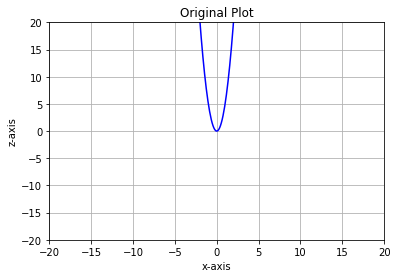

In [8]:
'''
not yet transformed plot:
'''

%matplotlib inline
test_frame_x, test_frame_y, test_frame_z = test_stack[:,0], test_stack[:,1], test_stack[:,2]
p.figure()
p.ylim(-20,20)
p.xlim(-20,20)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.title("Original Plot")
p.plot(test_frame_x,test_frame_z,'b-')

In [9]:
'''now if we rotate the plane about x, y, or z, we should see some changes.
below i defined the function rotateframe which i will use to rotate the plane of the graph about any of the axes.'''

def rotateframe(stack,Alpha,Beta,Gamma):
    newstack = np.zeros((point_density,3))
    for i in range(point_density): newstack[i,:] = np.transpose( ROT( np.transpose( stack[i,:] ), Alpha, Beta, Gamma) )
    return newstack[:,0], newstack[:,1], newstack[:,2]

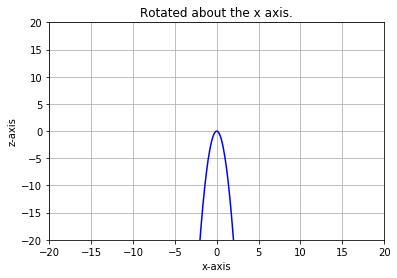

In [10]:
'''rotation about the x-axis'''

test_frame_x, test_frame_y, test_frame_z = rotateframe(test_stack,pi,0.,0.)
p.figure()
p.ylim(-20,20)
p.xlim(-20,20)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.title("Rotated about the x axis.")
p.plot(test_frame_x,test_frame_z,'b-')

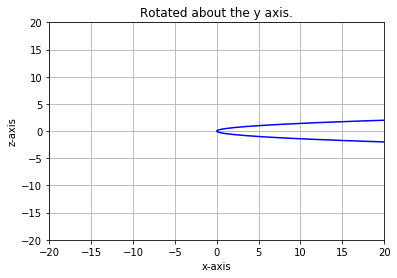

In [11]:
'''rotation about the y-axis'''

test_frame_x, test_frame_y, test_frame_z = rotateframe(test_stack,0.,0.5*pi,0.)
p.figure()
p.ylim(-20,20)
p.xlim(-20,20)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.title("Rotated about the y axis.")
p.plot(test_frame_x,test_frame_z,'b-')

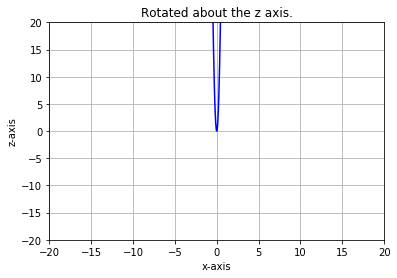

In [12]:
'''rotation about the z-axis'''

test_frame_x, test_frame_y, test_frame_z = rotateframe(test_stack,0.,0.,0.2*pi)
p.figure()
p.ylim(-20,20)
p.xlim(-20,20)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.title("Rotated about the z axis.")
p.plot(test_frame_x,test_frame_z,'b-')

As for raw, independent data points of x, y, and z which may be produced directly from experiments, they can be loaded into Python and rendered using a simple wireframe model of vertices and edges using the current output. We still want to be able to render 3D analytical functions and equations, however, as it is useful in science for simulations and fitting hypotheses to the real data. To demonstrate that the current output is capable of producing simple wireframe models and geometry.

We will now use FuncAnimation from the Matplotlib.animation FuncAnimation library, with which we can transform the data points before FuncAnimation updates these changes to the plot window continually. This effecively acts as a screen buffer.

Below are two example code cells of a wireframe lightning bolt, and a cube rotating in 3D, whereby x, y, and z are all independently given such as raw output from experiments.


**Wireframe Example 1: Lightning Path simulator using random generator**:

<IPython.core.display.Javascript object>


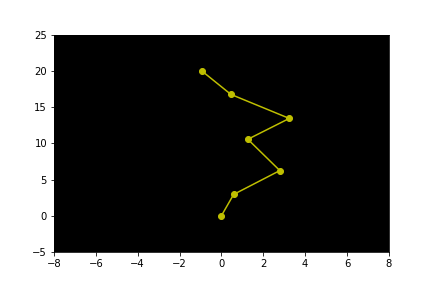

In [14]:
'''

    RANDOMLY GENERATED LIGHTNING PATH MODEL EXAMPLE
    
    Note: you may need to slightly adjust the view of the model 
    manually in the plot window.
    
'''

init_z = 20
point_density = 7
xyrange = 3
x = np.random.randint(-xyrange,xyrange,point_density)
y = np.random.randint(-xyrange,xyrange,point_density)
z = np.linspace(0, init_z,point_density)

lightning_stack = set_stack(newB(x,y,z) )
x1, y1, z1 = lightning_stack[:,0], lightning_stack[:,1], lightning_stack[:,2]

%matplotlib notebook


fig, ax = p.subplots()
line, = ax.plot(x1, z1,'yo-') 
ax.set_facecolor('#000000') #black background

def frame(i):
    
    newdata = rotateframe(lightning_stack, -0.3 , 0.0 * i, 0.2 * i)
    line.set_data(newdata[0] - newdata[0][0], newdata[2] - newdata[2][0]) # modified to fix the bottom point in x and z.
    ax.figure.canvas.draw()
    return line,

ani = FuncAnimation(fig, frame, 1000,interval=100, blit=False )


p.ylim(-5,25)
p.xlim(-2*xyrange-2,2*xyrange+2)
#p.grid() # no grid now!
p.show()



You will notice the optical illusion whereby you cannot tell if the lightning bolt is rotating clockwise/anticlockwise. This is due to there being no depth in the image. One way of rendering depth is using a Z-buffer; this is something we can discuss later.

**Wireframe Example 2: Cube rotating in all three axes**

<IPython.core.display.Javascript object>


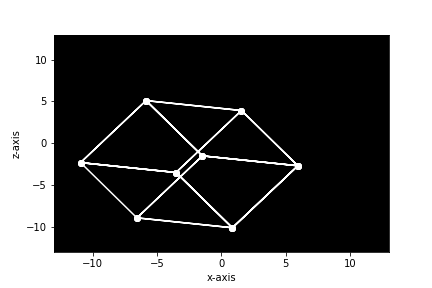

In [15]:
'''

    CUBE WIREFRAME MODEL EXAMPLE
    
    Note: you may need to slightly adjust the view of the model 
    manually in the plot window.
    
'''


point_density = 29 # must equal number of datapoints so keep this at 29.

L = 5 #length of sides


# each letter is a vector from the origin mapping to a vertex.
A = np.array([-L,+L,+L]) 
B = np.array([-L,+L,-L])
C = np.array([+L,+L,-L])
D = np.array([+L,-L,-L])
E = np.array([+L,-L,+L])
F = np.array([-L,-L,+L])
G = np.array([-L,-L,-L])
H = np.array([+L,+L,+L])

'''

here is the matrix of vectors joining from point to point to make a square
where each column is the x, y, and z values.
it is apparently impossible to draw a cube without 'lifting the pen of the paper'
i.e. without duplicating points.

'''

data = np.array([A,B,C,H,A,F,E,D,G,F,E,H,A,F,E,D,C,H,E,D,C,B,G,D,C,B,A,F,G,B]) 

x = data[:,0]
y = data[:,1]
z = data[:,2]

cube_stack = set_stack( newB(x,y,z) )
x1, y1, z1 = cube_stack[:,0], cube_stack[:,1], cube_stack[:,2]

%matplotlib notebook

fig, ax = p.subplots()
line, = ax.plot(x, z,'w-o')
ax.set_facecolor('#000000') #black background

def frame(i):
    
    newdata = rotateframe(cube_stack, 0.1 * i, 0.1 * i, 0.1 * i) # apply the rotation matrix transformation.
    line.set_data(newdata[0] - 0.5*L, newdata[2] -  0.5*L) # modified to fix rotation at centre of square.
    ax.figure.canvas.draw()
    return line,

ani = FuncAnimation(fig, frame, 1000,interval=10, blit=False)

p.ylim(-13,13)
p.xlim(-13,13)
p.xlabel("x-axis")
p.ylabel("z-axis")
#p.grid() # no grid now!
p.show()


# Creating and transforming a surface function z(x,y)

So far our outputs are not 3D surfaces, only 1D curves in 3D space. Below is one such example; here we use for our new test 3D function z(x,y) =  ( x^3 - 3x ) + ( y^3 - 3y ) as this will appear more antisymmetric when plotted, so that it is easier to observe the rotation in real time. 

<IPython.core.display.Javascript object>


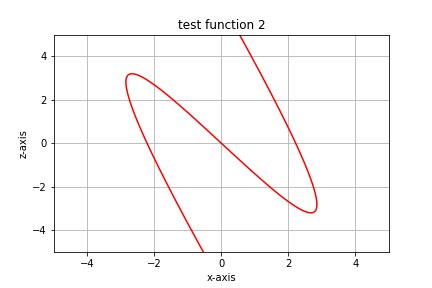

In [16]:

point_density = 5000

x = np.linspace(-50,50,point_density)
y = np.linspace(-50,50,point_density)
z = ( x**3 - 3*x ) + ( y**3 - 3*y )  #2*x**2 + y**2

test2_stack = set_stack( newB(x,y,z) )
x1, y1, z1 = test2_stack[:,0], test2_stack[:,1], test2_stack[:,2]

%matplotlib notebook


fig, ax = p.subplots()
line, = ax.plot(x1, z1,'r-')

def frame(i):
    newdata = rotateframe(test2_stack, 0.1 * i, 0.1 * i, 0.1 * i)
    line.set_data(newdata[0], newdata[2])
    ax.figure.canvas.draw()
    return line,

ani = FuncAnimation(fig, frame, 1000,interval=10, blit=False )


p.ylim(-5,5)
p.xlim(-5,5)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.title("test function 2")
p.show()

The shape is right, but so far we don't see a 3D solid shape, even though we have used our projection matrices to project all points, what we are looking at is a rotating slice of the 3D function. This is the x-z plane cutting through the origin of the function in our basis, which is then rotated under the rotation matrix operations. The result is then a curve instead of a surface.

We must be missing many points, which is why we are not seeing a solid shape as one would expect of a shadow. This becomes evident when we consider that our z values are only being calculated in our code using the same nth term in x and y, which is why the number of points in z is equal to the point density.

Where n is the point density, the z values should be mapped as:


$$z0   : (x0,y0)$$
$$z1   : (x0,y1)$$
$$z2   : (x0,y2)$$
$$.$$
$$.$$
$$.$$
$$zn   : (x1,y0)$$
$$zn+1 : (x1,y1)$$
$$zn+2 : (x1,y2)$$
$$.$$
$$.$$
$$.$$
$$z(n^2) : (xn,yn)$$

That is to say that we need an x by y matrix containing all of the z values, which are all the possible combinations of x and y both of size n. It follows that there are also n^2 values that must be defined for any one variable.

Simply consider some linear function z(x,y) and point density *n*, rearranged for x(z,y) or y(z,x), the data matrices will then be all the x-values in terms of all combinations of z and y, and all the y-values in terms of all combinations of z and x respectively. Either way, for a linear function, the plotted data is the same, and more to the point i wish to stress these matrices will remain to be size n x n as for the case z(x,y). Then there should be 2n^2 data points in a single plane, as the screen buffer is described by 2 variables each with n^2 each.

Our data size has somewhat exploded, and this will surely show in the perfromance during runtime for large values of n, which represents the size of the raw data. Nevertheless, we must modify our code to produce such an n x n matrix. (i.e with n^2 values). Below is code to produce the data matrix of z values. Setting the point density to 100, we will then want a 100x100 matrix of z-values.

In [49]:
point_density = 100

x = np.linspace(-50,50,point_density)
y = np.linspace(-50,50,point_density)

def f(x,y): return ( x**3 - 3*x ) + ( y**3 - 3*y ) #our antisymmetric test function
data_matrix = np.array([ [f(i,j) for j in y] for i in x]) # <- this is our z-matrix, where the nth column represents yn and the nth row represents xn

print("size of Matrix:",data_matrix.shape) # now we have 100x100 data points.

size of Matrix: (100, 100)


Now let us test this function with the modified code, but lets not animate it yet to see the initial output:

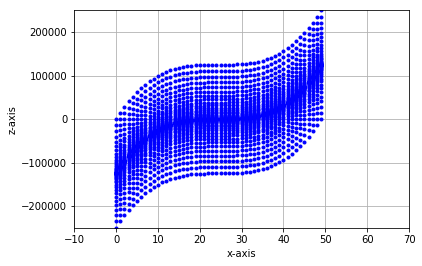

In [22]:
point_density = 50

x = np.linspace(-50,50,point_density)
y = np.linspace(-50,50,point_density)

def f(x,y): return ( x**3 - 3*x ) + ( y**3 - 3*y ) #our function


data_matrix = np.array([ [f(i,j) for j in y] for i in x]) 
# where row 0 is the y values for x = 0
# row 1 is the y values for x = 1
# etc.


# here we have created a set of vectors that corresponds the x,y and z values properly for all n^2 terms.
v_set =  np.array([ [  i, j, data_matrix[i,j] ] for j in range(point_density) for i in range(point_density) ]  )


x = v_set[:,0]
y = v_set[:,1]
z = v_set[:,2]

%matplotlib inline

fig, ax = p.subplots()
line, = ax.plot(x,z,'b.')

p.ylim(-250000,250000)
p.xlim(-10,70)
p.xlabel("x-axis")
p.ylabel("z-axis")
p.grid()
p.show()

This looks more like the shadow of our 3D function ( x^3 - 3x ) + ( y^3 - 3y ) in the x-z plane. Notice the concentration of data points in the centre-line, this tells us that it is projecting the points in the y axis (perpendicular to the plane) onto the screen, so we know that the projection matrix operation in newB is functioning properly.

Now we have the true shadow of our function in the x-z axis. we could render some depth using a z-buffer, which colourises each plot point a certain colour depending on it's z-value. However it may be beyond the limitations of matplotlib to colour each point differently and the update every colour each frame, the addition of which may be a topic for future development. For now, let us animate our 3D projection as we have it.

First, we need to update our 'rotateframe' and newB function to take (point_density^2) data points instead of (point_density) data points. Below are the new functions 'rotateframex' and 'newBx'.


In [45]:

def rotateframex(stack,Alpha,Beta,Gamma):
    newstack = np.zeros((point_density**2,3))
    for i in range(point_density**2): newstack[i,:] = np.transpose( ROT( np.transpose( stack[i,:] ), Alpha, Beta, Gamma) )
    return newstack[:,0], newstack[:,1], newstack[:,2]

def newBx(x,y,z,B=(ket_i,ket_j,ket_k)):
    
    k_i, k_j, k_k = B
    
    b_i = np.conjugate( np.transpose(k_i) )
    b_j = np.conjugate( np.transpose(k_j) )
    b_k = np.conjugate( np.transpose(k_k) )

    PI = (k_i @ b_i) / (b_i @ k_i)[0][0]
    PJ = (k_j @ b_j) / (b_j @ k_j)[0][0]
    PK = (k_k @ b_k) / (b_k @ k_k)[0][0]
    
    return np.array([newV(np.array([[x[i]],[y[i]],[z[i]]]), (PI,PJ,PK)) for i in range(point_density**2) ])

# Results

**below is the result for the test function ( x^3 - 3x ) + ( y^3 - 3y ), using our data matrix, newBx and rotateframex:**

<IPython.core.display.Javascript object>


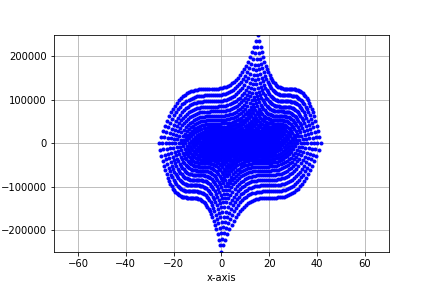

In [44]:
'''

    FUNCTION ( x^3 - 3x ) + ( y^3 - 3y ) MODEL.
    
    Note 1: This code may take time to load, and may cause your hardware's fans to start.
    
    Note 2: You may need to slightly adjust the view of the model 
            manually in the active plot window.

'''

point_density = 50

x = np.linspace(-50,50,point_density)
y = np.linspace(-50,50,point_density)

def f(x,y): return  ( x**3 - 3*x ) + ( y**3 - 3*y )

data_matrix = np.array([ [f(i,j) for j in y] for i in x]) 
# where row 0 is the y values for x = 0
# row 1 is the y values for x = 1
# etc.

v_set =  np.array([ [  i, j, data_matrix[i,j] ] for j in range(point_density) for i in range(point_density) ]  )

x = v_set[:,0]
y = v_set[:,1]
z = v_set[:,2]

# pass it into newBx to convert to the desired basis set
function_1_stack = set_stack(newBx(x,y,z))

%matplotlib notebook

fig, ax = p.subplots()
line, = ax.plot(x,z, 'b.')

def frame(i):
    newdata = rotateframex(function_1_stack, 0.00 * i, 0.00 * i, 0.05 * i)
    line.set_data(newdata[0], newdata[2])
    ax.figure.canvas.draw()
    return line,

ani = FuncAnimation(fig, frame, 1000, init_func=None, interval=10, blit=False )

p.ylim(-250000,250000)
p.xlim(-70,70)
p.grid()
p.xlabel("x-axis")
p.ylabel("z-axis")
p.show()

**We return also to the original test function ( 2x^2 + y^2 ):**

<IPython.core.display.Javascript object>


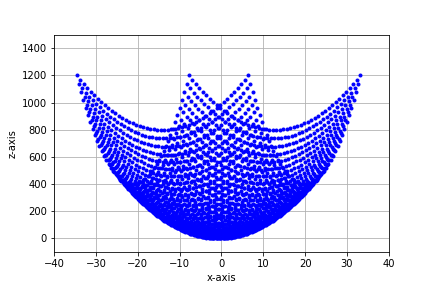

In [54]:
'''

    FUNCTION ( 2x^2 + y^2 ) MODEL.
    
    Note 1: This code may take time to load, and may cause your hardware's fans to start.
    
    Note 2: You may need to slightly adjust the view of the model 
            manually in the active plot window.

'''

point_density = 50

x = np.linspace(-20,20,point_density)
y = np.linspace(-20,20,point_density)

def f(x,y): return 2*x**2 + y**2

data_matrix = np.array([ [f(i,j) for j in y] for i in x]) 
# where row 0 is the y values for x = 0
# row 1 is the y values for x = 1
# etc.

v_set =  np.array([ [  i, j, data_matrix[i,j] ] for j in range(point_density) for i in range(point_density) ]  )


x = v_set[:,0]
y = v_set[:,1]
z = v_set[:,2]

# pass it into newBx to convert to the desired basis set
function_2_stack = set_stack(newBx(x,y,z))

%matplotlib notebook

fig, ax = p.subplots()
line, = ax.plot(x,z, 'b.')


def frame(i):

    newdata = rotateframex(function_2_stack, 0.0 * i, 0.0 * i, 0.05 * i)
    line.set_data(newdata[0] - newdata[0][ np.where(z==min(z))[0][0] ], newdata[2] - newdata[2][ np.where(z==min(z))[0][0] ] ) # modification to fix rotation about minimum
    ax.figure.canvas.draw()
    return line,

ani = FuncAnimation(fig, frame, 1000, init_func=None, interval=10, blit=False )

p.ylim(-100,1500)
p.xlim(-40,40)
p.xlabel("x-axis")
p.ylabel("z-axis")
p.grid()
p.show()

Supposing we want to plot a parametric function with just a set of parametric equations. We now need a data matrix each for x, y, and z in terms of our parameters. An example parametric function is the parametric equation of a torus, in terms of angles theta and phi.

<IPython.core.display.Javascript object>


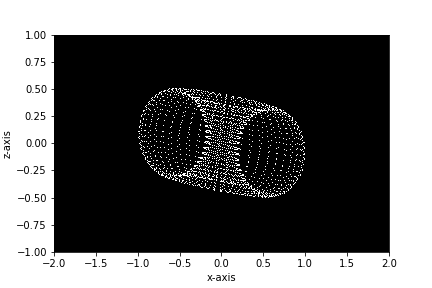

In [51]:
'''
    TORUS  MODEL.
    
    Note 1: This code may take time to load, and may likely cause your hardware's fans to start.
            If the performance is too poor, try halving the point density. If you do so, you may
            want to change the plotting marker in the code from ',' to '.' for better clarity
    
    Note 2: You may need to slightly adjust the view of the model 
            manually in the active plot window.

'''

point_density = 50
theta = np.linspace(0,2*pi,point_density)
phi = np.linspace(0,2*pi,point_density)
R = 0.6
r = 0.4

# we need our three parametric functions in terms of our parameters theta and phi
def x(theta=theta,phi=phi): return (R + r*cos(theta))*cos(phi) 
def y(theta=theta,phi=phi): return (R + r*cos(theta))*sin(phi)
def z(theta=theta,phi=phi): return r*sin(theta)

'''
each of x, y, and z need a matrix containing their values for all combination pairs of parameters 
theta and phi, as before when we needed all combinations of the variables x and y for our function z.
''' 
x_matrix = np.array([ [x(i,j) for j in theta] for i in phi]) # data matrix for x
y_matrix = np.array([ [y(i,j) for j in theta] for i in phi]) # data matrix for y
z_matrix = np.array([ [z(i,j) for j in theta] for i in phi]) # data matrix for z

'''
we then want to extract only the range of x, y, and z values by themselves. We can do without the corresponding
theta and phi values because we are plotting in a plane described by cartesian coordinates.
'''

x_set =  np.array([ x_matrix[i,j] for j in range(point_density) for i in range(point_density) ]  ) # x values
y_set =  np.array([ y_matrix[i,j] for j in range(point_density) for i in range(point_density) ]  ) # y values
z_set =  np.array([ z_matrix[i,j] for j in range(point_density) for i in range(point_density) ]  ) # z values



'''now we can put them into our tried and tested code.'''
# pass it into newBx to convert to the desired basis set
torus_stack = set_stack(newBx(x_set,y_set,z_set))

%matplotlib notebook

fig, ax = p.subplots()
line, = ax.plot(x_set, z_set,'w,') # change 'w,' to 'w.' if you need better clarity
ax.set_facecolor('#000000') #black background

def frame(i):

    newdata = rotateframex(torus_stack, 0.05 * i, 0.1 * i, 1. * i)
    line.set_data(newdata[0], newdata[2])
    ax.figure.canvas.draw()

    return line,

ani = FuncAnimation(fig, frame, 1000,interval=10, blit=False )

p.ylim(-1,1)
p.xlim(-2,2)
p.xlabel("x-axis")
p.ylabel("z-axis")
#p.grid()
p.show()


# Observations

**Collapsing of data with non square plot window**

Currently, when the x-limits do not match the z-limits in the screen buffer (animated plot window), a rotation about the axes causes the image to collapse due to scaling effects. Restricting the frame buffer to a square aspect ratio limits ones analysing capabilities. We can implement code to counter this by renormalising. However, this means more tasks per frame update, and puts more work on the computer's limited memory.

**Moving off-axis**

The raw data plots such as the cube, and the explicit functions appeared to move off axis as they rotated. We were able to implement code to correct for this by fixing the position of a chosen coordinate. The parametric model did not exhibit this effect, so to suggest that parameterisation has better advantages for the method employed.

**Size of data**


We found that the handling of data grew relatively larger than first expected

For an explicit surface function g(x,y,z,p,q,r...N), the size is
$$2n^N$$ 
corresponding to the tensor of size 
$$\prod_{}^{N} n$$ 

for each variable, where N is the number of controlled variables.
In our case we used 3 dimensional space, then we the size ouf our data for an explicit function z(x,y) will be:
$$2n^2$$, 
(each variable x, y, and z had n x n values, plotting two variables on the screen buffer) 

for rendering raw data, such as the cube the point density is equal to the number of raw data points required to describe the complete path. for the simpler wireframe lightning model, the size of the data is the number of conecting points.


Having x, y, and z parametrised allows for full view in all rotations. Then moving forward, it makes sense to parametrise where possible.

# USES

The wireframe model version has its use in modelling lattices in solid state Physics, or bonds in chemistry, where one can input the lattice vectors or atom positions to visualise the structure of a crystal by plottting points, or its unit cell by plotting lines.

The surface model version has uses in modelling Physical surfaces, such as a (P,V,T) surface in thermodynamics. 

The rotateframe and rotateframex tasks can be further developed to perform more transformations, perhaps ones that simulate physical/chemical processes in real time such as the effects of gravity or an acting force.

# POINTS FOR IMPROVEMENT

**VISUALISATION:**

Currently, one will have noticed a lack of depth perception in all of the models; you cannot tell whether you are looking at the object rotating clockwise or anticlockwise by looking. A z-buffer would eliminate this issue at least for the surface model. This would comprise of code which stylises each point depending on its z-value. This could be done by colour-map, or by size of marker, e.g a smaller marker like ',' if it is further into the plane and 'o' if it is further out of the plane. The limitations of Matplotlib and the animation library are to be investigated to see if this is possible.

**OPTIMISATION:**

Optimisation of the code through means of exploring different programmatic methods, and timing speeds can enhance the smoothness of the rendering, which may allow more sophisticated functions and models to be visualised. There is room for further modularisation, so that the code is easier to read and develop. A GPU is far better suited for rendering large data structures than a CPU. While using a CPU, we have experienced slow framerates in runtime and heating up of devices. Parallel programming, with a dedicated GPU would accelerate the speed of rendering, and the code cwill be able to handle more data, Making it more suitable for scientific analysis.

Using a compiled language such as C will improve speeds, since interpreted language like Python needs to be reprocessed every time. However, the program may then be less portable to other devices with different architectures.

What we have currently produced demonstrates that the python library is capable of plotting 3 dimensional data, however its suitability as a medium for scientific analyses of large data, such as that seen in modern experiments like ATLAS and ESS, is not supported by what has been observed. In order to visualise data graphically in 3D, depth perception is important. The standard Matplotlib library does not have an immediately obvious way of making a z-buffer. This is one of two paramount requirements for graphic data analysis. The code also needs to be able to handle large data. The method used has shown to be cumbersome with large data, and there is definitely potential for optimisation; Object oriented languages such as C are better suited because they handle memory more efficiently. However, using a GPU for larger tasks is more suitable than using a CPU, as we have done. It remains to be seen how techniques such as parallel programming may improve our method. 

# References